Hey, in this notebook we are going to be building a CNN for binary classification using different datasets. In this, we are going to be predicting either Benign (0) or Malignant (1).

In the process, we are going to be taking the following steps:

1.   Upload out dataset zip file
2.   Process that zip file into a more usable form
3.   Prepare the dataset for use
4.   Import a pre-trained model and adapt it for our use
5.   Train and test our new model

In future notebooks, we are going to continue where this notebook leaves off. So, in future notebooks we will do the following:

1. Do more in-depth testing using other datasets to assess bias.
2. Fine-tune the models made here with other datasets to (hopefully) reduce bias and increase our overall accuracy.

**IMPORTANT NOTES ABOUT PUBLIC UPLOAD VERSION**

1. Some parts of the code below have been removed and replaced with either comments indicating what they did, or by setting variables equal to "None". This is done as some code contained either information relating to API keys or local directory structures. The information was removed for privacy. If you have any concerns on what data should be placed there, send me an email and I will provide any support that is necessary to assist you.
2. This notebook is not meant to be run in its entirety. It contains multiple paths depending on the kind of testing that we wish to run. If you run every cell in order, you will encounter an error. Sections where every cell is not meant to be run are marked clearly and include notes on how to proceed with running.
3. All or most of the cell outputs have been removed to reduce comfusion and to ensure the privacy of some of the data (since this is all medical data). If you are interested in the output of any of the cells (ex: the training/validation accuracy and loss), send me an email and I can send it to you if it is available.

# **Imports and Useful Functions**

The code below will import and install any required packages or libraries. As always, run this code first when you start up the notebook.

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

import numpy as np

import tensorflow as tf
from tensorflow import keras
import keras.layers as tfl

import sklearn
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from glob import glob
from google.colab import files

import io
import gc

print(tf.version.VERSION)

This function below will just make a beeping sound when it is called. Feel free to call this function at the end of a cell which will take a long time to run so that you don't need to watch it.

In [ ]:
from google.colab import output

def beep():
  output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

# **Uploading the Dataset Zip File**

The first thing that we need to do is actually upload our zip file for our dataset.

There's a couple of options for how we can upload our datasets. Since google colabs doesn't run locally, we have to upload our data to our current session.

Some options that we have are to:

1.   Upload local files directly into our current session
2.   Mount a google drive to upload files
3.   Upload kaggle datasets with their API


They all have their benefits and problems, but you just have to pick one that works best for the dataset that you are using. Just pick one of the following methods as they are all achieving the same end goal.



## **(a) Simply Uploading Local Files**

The easiest option is just to upload a local file that you have into the session. Just make sure that you upload it as a zip file to make it easy. The code below can be used to upload any file you would like.

While this method is really easy to do, it takes a really long time. Depending on your internet speed, it will take roughly 15 minutes per 1 GB of data. So, I don't really reccomend this method if you can avoid it.

In [ ]:
files.upload()

## **(b) Mount Your Google Drive**

Another option for uploading files is to mount your drive to the current session. This will let you access files which are stored **in your drive** to the current session. However, you have to be careful when using this method. Since the files stored on your drive are not stored in the current session, transfering files between the two can be very slow. If you store all of your unzipped data on your drive, it will be very slow when it comes to training/testing. However, if you unzip the file into your current session, you can get around this and greatly speed up the whole process.

If you use this method, make sure that file paths are set up correctly later on as I will be assuming that the zip file you are trying to use is in the /content folder.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Don't run this now**, but when you are done using this notebook, make sure that you un-mount your drive with the following command.

In [ ]:
# ONLY RUN WHEN DONE WITH NOTEBOOK
drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')

All changes made in this colab session should now be visible in Drive.


## **(c) Getting Images From Kaggle**

One of the options that we have for uploading datasets is to use the kaggle API. However, this will only work for datasets that were taken from kaggle.com. If one that we want to use isn't on the website, I'm pretty sure that I'm able to upload it myself, so we can play around with that.

Before we can use the kaggle API, we have to setup an API key. Normally, you would get their free key from the website and upload the json file here. But, I went ahead and just set it up in the code so that you don't need to worry about the API key file or getting your own API key.

**IMPORTANT NOTE: THE FOLLOWING CODE HAS BEEN ALTERED TO REMOVE API KEYS. FOR THIS CODE TO RUN, YOU WILL NEED TO UPLOAD A VALID KAGGLE API KEY FILE INTO THE ~/.kaggle/kaggle.json FILE**

In [ ]:
# Set up the API Key
!pip install -q kaggle
!mkdir -p ~/.kaggle
# LINE REMOVED WHICH INCLUDED AN API KEY
!chmod 600 ~/.kaggle/kaggle.json

Now that we have finished setting up the API, we can simply download it. To get this command, click on the three dots in the top right of any dataset, and click "Copy API Command". Just make sure to add the ! in front of the command that it gives you as it is not a python command.

For example, to download the HAM10000 dataset, you can use:

```
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
```



In [ ]:
# !!!! CHANGE THIS FOR EACH DATASET!!!!
# Download the dataset using the kaggle API
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign
beep()

 99% 323M/325M [00:04<00:00, 67.3MB/s]
100% 325M/325M [00:04<00:00, 82.1MB/s]


# **Setting Up The Dataset**

Now that we have set up our dataset, we can go ahead and process our zip file into a usable form. This will ultimately mean Tensorflow Dataset objects.

Depending on which dataset we are going to be using, I have provided code to set up the different datasets. Follow the code for the matching dataset. **Do not run the code for more than one dataset** (marked by a, b, c, or d). While each section has some redundant code, I have included copies of it to reduce the chance that user errors are made when running the code. However, below I have included the variables and hyper-parameters that are used in all three datasets, that we will want to keep steady between tests. Please set them as you like, but the current setup provides good results on all datasets we have.

In [ ]:
# !!!! DATASET VARIABLES AND HYPER-PARAMETERS !!!!
# The new image size to resize to (matches our models input size)
new_img_size = (224, 224)

# The size of the training set (as a proportion)
TRAIN_SIZE = 0.8
assert 0 <= TRAIN_SIZE <= 1, "ERROR -- INVALID TRAIN_SIZE -- Must be between [0, 1]"

# The batch size to use
BATCH_SIZE = 64

## **(a) Setting up PAD-UFES-20**

Here, we are going to be setting up the PAD-UFES-20 dataset.

Firstly, we just want to unzip our zip file. Make sure to set the value of "ds_path" to the path of the zip file.

In [ ]:
# !!!! SET THE FILE PATH FOR THE DATASET !!!!
ds_path = None

# Unzip the dataset into the content folder and remove the unnecesary mac folder
!unzip "$ds_path" -d /content
!rm -r '/content/__MACOSX'

Now, we are just going to set a bunch of variables that we are going to use throughout the following code.

**PUBLIC RELEASE NOTE:** The values for base_dataset_dir and metadata_path may not work for you as these are based on the private setup that was used during the project. If running this code privately, please be sure that all of the below variables are set properly. Otherwise, you will most certainly encounter an error.

In [ ]:
# VARIABLES TO SET TO MATCH THE DATASET
base_dataset_dir = '/content/PAD-UFES-20'
metadata_path = '/content/PAD-UFES-20/PAD-UFES-20-metadata.csv'

# The filetype of the images
image_type = 'png'

# The column that has the file name for each image (usually an id number)
img_file_col = 'img_id'

# Dataframe column name with original classification
orig_label_col = 'diagnostic'

# The column name with the fitzpatrick score
fitz_col = 'fitspatrick'

Now, we can go ahead and read in our metadata file so that we can begin to process the dataset.

In [ ]:
df = pd.read_csv(metadata_path)
df.head()

Here, we are just going to remove all of the columns that will be unused. This step is not necessary, but may be helpful when trying to troubleshoot issues.

In [ ]:
# Get rid of unused columns
df = df[[img_file_col, orig_label_col, fitz_col]]
df.head()

Now, we can go ahead and prepare out dataframe. We want to do two things. Create binary labels from our diagnostics, and aggregate our fitzpatrick data.

Firstly, we will just aggregate the fitzpatrick label information.

So, Labels 1 & 2 become 12, 3 & 4 become 34, and 5 & 6 become 56.

In the process, we will also reject any images that don't have a provided fitzpatrick value.

In [ ]:
# Aggregate the fitzpatrick information
df = df.loc[df[fitz_col].notna()]
df[fitz_col] = df[fitz_col].astype(int)
agg_fitz_vals = [12, 34, 56]
df['agg_fitz'] = df[fitz_col].map(lambda x: agg_fitz_vals[int((x - 1) / 2)])
df.head()

Next, we are just going to convert the provided diagnostic categories into our binary labels (malignant vs benign).

In [ ]:
# Define the categories in our dataset
categories = ['Benign', 'Malignant']

# Define a map tying the diagnostic labels to binary lables
label_ind_dict = {
    'ACK': 0,
    'BCC': 1,
    'MEL': 1,
    'NEV': 0,
    'SCC': 1,
    'SEK': 0
}

# Add binary label indexes (0 or 1) and the matching label (see categories list above)
df['label_ind'] = df['diagnostic'].map(label_ind_dict.get)
df['label'] = df['label_ind'].map(lambda x: categories[x])
df.head()

,img_id,diagnostic,fitspatrick,agg_fitz,label_ind,label
1,PAT_46_881_939.png,BCC,3,34,1,Malignant
4,PAT_684_1302_588.png,BCC,1,12,1,Malignant
6,PAT_778_1471_835.png,BCC,3,34,1,Malignant
7,PAT_117_179_983.png,BCC,1,12,1,Malignant
9,PAT_705_4015_413.png,ACK,1,12,0,Benign


Now, the last thing that we need to do is match each image in our metadata dataframe to its actual file path. This way, we can construct our dataset object where we match the file paths with their labels to in turn match images (as eager tensors) with their labels.

To do this, we are going to read through all of the images with the matching image type that follow this structure.


```
base_dataset_dir
  img_dir_1
    img_1
    img_2
    ...
  img_dir_2
    img_3
    img_4
    ...
  ...
```



In [ ]:
# Make sure that base dataset directory exists
print("Dataset Directory Exists: " + str(os.path.exists(base_dataset_dir)))

# Make a dictionary matching img_id -> img_path for all files
imageid_path_dict = {os.path.basename(x): x
                     for x in glob(os.path.join(base_dataset_dir, '*', '*.' + image_type))}

# Print the number of images found in the dictionary for error checking
print("Number of Images in Dictionary: " + str(len(imageid_path_dict)))

# Map the image ids to their paths
df['path'] = df['img_id'].map(imageid_path_dict.get)

df.head()

Now that we have the dataframe for our dataset all set up, let's look at the distribution of our dataset. For this, we are going to look at the distribution of our labels (to see how imbalanced the dataset is in terms of labels) and the distribution of fitzpatrick types (to see how imbalanced the dataset is in terms of fitzpatrick types).

Firstly, we'll define a function which will make these plots for us.

In [ ]:
# Given a dataframe and a category, plots a bar chart of those values
def show_bar_dist(df, cat):
  # Plot the distribution with its percentage.
  fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
  ax = df[cat].value_counts().plot(kind='bar', ax=ax1, title=cat + ' Distribution')
  ax.bar_label(ax.containers[0])

  counts = df[cat].value_counts()
  percents = counts.map(lambda x: (x / counts.sum()) * 100.0)
  print("Percentages: ")
  print(percents)

Percentages: 
Malignant    72.891566
Benign       27.108434
Name: label, dtype: float64


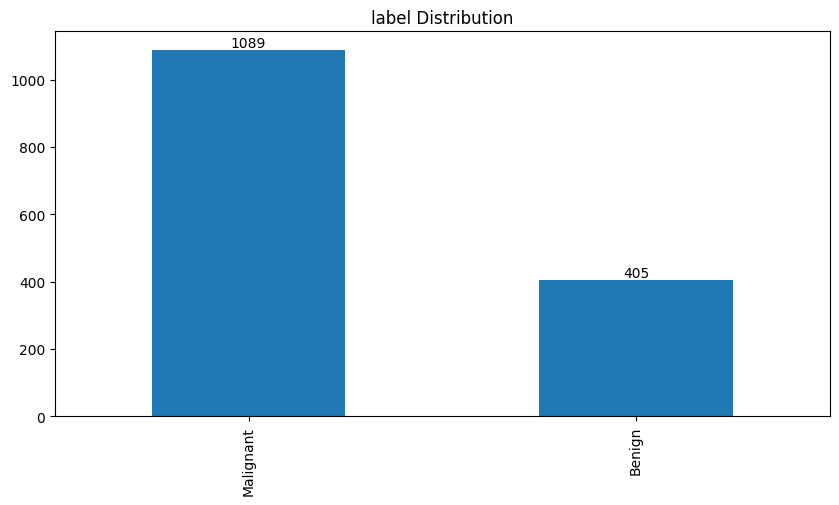

In [ ]:
# Plot the distribution of labels in the dataset
show_bar_dist(df, 'label')

Percentages: 
12    68.875502
34    30.388220
56     0.736278
Name: agg_fitz, dtype: float64


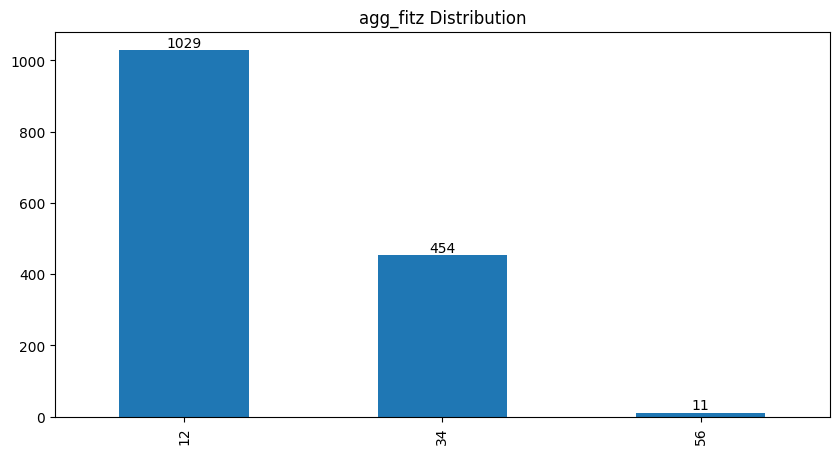

In [ ]:
# Plot the distribution of aggregated fitzpatrick types in the dataset
show_bar_dist(df, 'agg_fitz')

Now, we can split up the dataset into a train set and a test set.

Note, because of the size of our datasets (being small), we are not going to have a separate validation set. We will just use our test set as a validation set.

In [ ]:
# Split the dataframe into multiple sets
train_df, test_df = train_test_split(df, test_size= 1.0 - TRAIN_SIZE)

# Extract the image file paths and labels
train_paths = train_df['path'].to_numpy()
train_labels = train_df['label_ind'].to_numpy()
test_paths = test_df['path'].to_numpy()
test_labels = test_df['label_ind'].to_numpy()

# Create the dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

Now that we have the basic dataset objects, we want to do two things.

1. Convert file paths to images (as eager tensors) and resize them to the size that our model requires.
2. Optimize our dataset object to improve performance during training/testing.

In [ ]:
# Reads in an image given its file path and resizes it to new_img_size
@tf.function
def prepare_image(file_path, label):
  # Read in the image
  image = tf.io.read_file(file_path)
  image = tf.image.decode_image(image, channels=3, expand_animations=False)
  # Resize the image
  image = tf.image.resize(image, new_img_size)
  return image, label

# Prepare the images for each dataset
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.map(prepare_image, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.map(prepare_image, num_parallel_calls=AUTOTUNE)

In [ ]:
# Configures a dataset object to increase performance, including batching the dataset
def configure_for_performance(ds, batch_size):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size = 1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size = AUTOTUNE)
  return ds

# Configure both datasets to increase performance
train_dataset = configure_for_performance(train_dataset, BATCH_SIZE)
test_dataset = configure_for_performance(test_dataset, BATCH_SIZE)

Now, our datasets are all setup. So, we can begin to setup our model.

## **(b) Setting up Fitzpatrick 17k**

Here, we are going to be setting up the Fitzpatrick 17k dataset.

**PUBLIC RELEASE NOTE:** This dataset is not publicly available as it is only meant for research. Since it was used during our research, I am leaving it in this file. However, please not that the following code is not meant to be used publicly. Further, some of the variables have been omitted below for privacy reasons.

As with the other datasets, we will first start by setting up some variables to match our dataset.

In [ ]:
# VARIABLES TO SET TO MATCH THE DATASET
base_dataset_dir = None
metadata_path = None
ds_path = None

# The filetype of the images
image_type = 'jpg'

# The column that has the file name for each image (usually an id number)
img_file_col = 'md5hash'

# Dataframe column name with original classification
orig_label_col = 'three_partition_label'

# The column name with the fitzpatrick score
fitz_col = 'fitzpatrick_scale'

In [ ]:
!unzip "$ds_path" -d /content

Now that the dataset has been unzipped, we can start to process it by setting up the metadata with a dataframe.

In [ ]:
classes = ['Benign', 'Malignant']

# Read in the metadata
df = pd.read_csv(metadata_path)

# Make a dictionary matching imgage id -> image path for all files
imageid_path_dict = {os.path.basename(x): x
                     for x in glob(os.path.join(base_dataset_dir, '*', '*.' + image_type))}

# Add image paths to the dataframe
df['path'] = df[img_file_col].map(imageid_path_dict.get)

# Print a summary of the files found and the existing file counts for error checking
print("Number of Image Paths Found:          " + str(len(imageid_path_dict)))
print("Number of Images in DataFrame:        " + str(len(df)))
print("Number of Images in Target Directory: ", end='')
!ls /content/data/finalfitz17k -1 | wc -l

Number of Image Paths Found:          16577
Number of Images in DataFrame:        16577
Number of Images in Target Directory: 16577


Now, we can go ahead and convert our existing labels (benign, malignant, non-neoplastic), into binary labels (0, 1). We are also going to get rid of all images that are labeled as non-neoplastic and any images which don't have fitzpatrick data.

In [ ]:
# Define a dictionary to map labels to integer labels
class_dict = {
    'benign': 0,
    'malignant': 1,
    'non-neoplastic': -1
}

# Extend the dataframe to have the refined labels
df['label_ind'] = df[orig_label_col].map(class_dict.get)
df['label'] = df['label_ind'].map(lambda x: classes[x])

# Drop all data points without a Fitzpatrick rating
df = df[df[fitz_col].notna()]

# Drop all data points that are in non-neoplastic
df = df[df['label_ind'] != -1]

df.head()

Since we have done a separate analysis on this dataset in another notebook, I have not provided any code to analyze the distribution of various parameters here. Please see the more in-depth notebook on analyzing this dataset for such information.

Now that the dataframe is setup, we are going to make the actual dataset objects. As usual, we are going to do an 80-20 split here.

In [ ]:
# Split the dataframe into multiple sets
train_df, test_df = train_test_split(df, test_size = 1.0 - TRAIN_SIZE)

# Extract the image file paths and labels
train_paths = train_df['path'].to_numpy()
train_labels = train_df['label_ind'].to_numpy()
test_paths = test_df['path'].to_numpy()
test_labels = test_df['label_ind'].to_numpy()

# Create the dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

Now that we have the basic dataset objects, we want to do two things.

1. Convert file paths to images (as eager tensors) and resize them to the size that our model requires.
2. Optimize our dataset object to improve performance during training/testing.

In [ ]:
# Reads in an image given its file path and resizes it to new_img_size
@tf.function
def prepare_image(file_path, label):
  # Read in the image
  image = tf.io.read_file(file_path)
  image = tf.image.decode_image(image, channels=3, expand_animations=False)
  # Resize the image
  image = tf.image.resize(image, new_img_size)
  return image, label

# Prepare the images for each dataset
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.map(prepare_image, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.map(prepare_image, num_parallel_calls=AUTOTUNE)

In [ ]:
# Configures a dataset object to increase performance, including batching the dataset
def configure_for_performance(ds, batch_size):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size = 1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

# Configure both datasets to increase performance
train_dataset = configure_for_performance(train_dataset, BATCH_SIZE)
test_dataset = configure_for_performance(test_dataset, BATCH_SIZE)

Now our dataset is all ready to use so we can start setting up our model.

## **(c) Setting up HAM 10000**

Here, we are going to be setting up the HAM 10000 dataset.

In [ ]:
# VARIABLES TO CHANGE WHEN CHANGING DATASETS
# The file type of the images
image_type = 'jpg'

# The csv file containing metadata. Should be directly in datasets directory
metadata_filename = None

# Column names from the metadata
label_col_name = 'dx'     # The name of the column which contains the provided label (eg nv, mel, bkl, etc.)
data_key = 'image_id'     # The name of the column which can uniquely identify an image (usually the filename)

# Set up a dictionary to classify as Melanoma, Carcinoma, or Benign
lesion_type_dict = {
    'nv': 'Benign',            # Melanocytic nevi (Pre-Cancerous)
    'mel': 'Malignant',         # Melanoma
    'bkl': 'Benign',           # Benign keratosis-like lesions
    'bcc': 'Malignant',        # Basal cell carcinoma
    'akiec': 'Benign',         # Actinic keratoses (Pre-Cancerous)
    'vasc': 'Benign',          # Vascular lesions
    'df': 'Benign'             # Dermatofibroma
}

Firstly, we just want to unzip the dataset and put everything in one folder so that we can process everything.

For this dataset, you should have downloaded it using the kaggle API, so if you encounter an error, just make sure that the file path for the zip file is correct.

In [ ]:
# Unzip the dataset
!mkdir dataset
!unzip '/content/skin-cancer-mnist-ham10000.zip' -d dataset
beep()

Now, with this dataset, we get some unnecessary duplicate folders. So, we are just going to delete those here.

In [ ]:
# Remove duplicate folders
!rm -r '/content/dataset/ham10000_images_part_1'
!rm -r '/content/dataset/ham10000_images_part_2'

Since we have multiple folders of images, we want to have a list of all of the images (meaning their filepaths) in one place, so that we can easily process everything. Make sure that the number of images that we read match what was expected.

In [ ]:
# Setup the filepath for the base directory of the dataset
base_dataset_dir = '/content/dataset'
print("Dataset Directory Exists: " + str(os.path.exists(base_dataset_dir)))

# Make a dictionary with all file paths from specified folders
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_dataset_dir, '*', '*.' + image_type))}

# Print a report on the number of images found
print("Number of Images: " + str(len(imageid_path_dict)))

Dataset Directory Exists: True
Number of Images: 10015


Since for our dataset, we are given a folder(s) of images without their labels directly attached, we first have to process the pictures to match everything up with their labels. To do this, we have to process the metadata csv file which contains all of the metadata for each image, which includes their label.

This can be done basically automatically by the pandas library, which will put it into something called a DataFrame (hence the df). It is basically just a 2D array where each row is one line from the csv file, meaning one line is the information for one image.

Now we can begin to process the metadata. The dataset should have a csv file with the metadata. Make sure that it is directly in dataset folder.



In [ ]:
# Read the metadata csv file
df = pd.read_csv(os.path.join(base_dataset_dir, metadata_filename))

# Print an overview of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


Now, since we are really only interested in classifying as melanoma, carcinoma, or benign, we need to alter our metadata a little bit to reflect this. Make sure that they keys of the lesion_type_dict reflect what is in the dataset.

As a note, we have to make some decisions regarding the classification of pre-cancerous skin lesions. Melanocytic nevi and Actinic keratoses are both considered pre-cancerous. However, since all of these diagnoses have been confirmed with histopathology, we can consider them to be non-cancerous.

Here, we are going to add the file paths, binary labels (Benign/Maligmant) and our binary label indexes (0, 1) to each image in our dataframe.

In [ ]:
# Create a map for for our binary labels
label_ind_dict = {
    'Benign': 0,
    'Malignant': 1
}

# Add file paths, labels, and label indexes to the dataframe
df['path'] = df[data_key].map(imageid_path_dict.get)          # Get a filepath for each image
df['label'] = df[label_col_name].map(lesion_type_dict.get)    # Use the lesion dictionary to map lesion type to classification
df['label_ind'] = df['label'].map(label_ind_dict.get)

# Print the first few items in the metadata dataframe as an example
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,label,label_ind
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/dataset/HAM10000_images_part_1/ISIC_0...,Benign,0
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/dataset/HAM10000_images_part_1/ISIC_0...,Benign,0
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/dataset/HAM10000_images_part_1/ISIC_0...,Benign,0
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/dataset/HAM10000_images_part_1/ISIC_0...,Benign,0
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/dataset/HAM10000_images_part_2/ISIC_0...,Benign,0


Here we can also visualize the distribution of the dataset for different categories. Play around with it to find out more about the dataset.

Percentages: 
Benign       83.754368
Malignant    16.245632
Name: label, dtype: float64


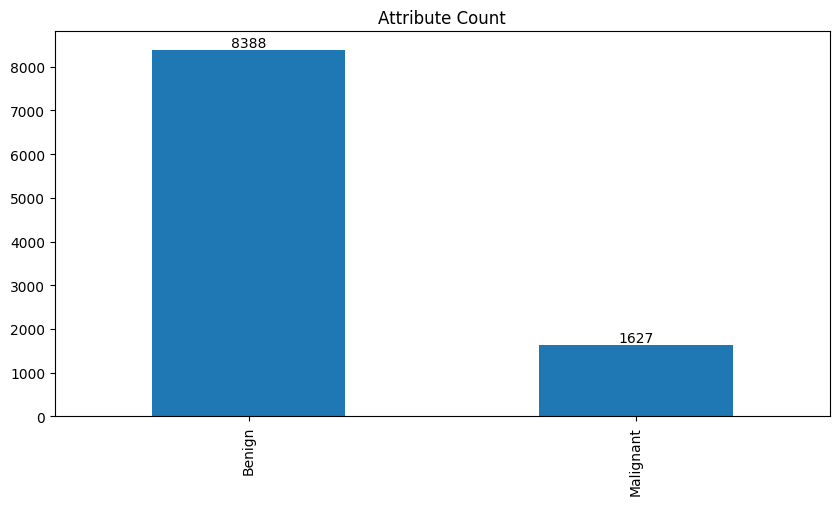

In [ ]:
# CHANGE THIS TO PLOT DIFFERENT CATEGORIES
category_to_chart = 'label'

# Plot the distribution with its percentage.
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
ax = df[category_to_chart].value_counts().plot(kind='bar', ax=ax1, title='Attribute Count')
ax.bar_label(ax.containers[0])

counts = df[category_to_chart].value_counts()
percents = counts.map(lambda x: (x / counts.sum()) * 100.0)
print("Percentages: ")
print(percents)

Notice how there's an imbalance in the data. When looking at 'label' (for the HAM10000 dataset), 83.7% of images are benign. This is going to provide some troubles when we want to train as we want these numbers to ideally be more equal.

Now, we can go ahead and create our dataset objects. We will make one training and one testing set.

In [ ]:
# Split the dataframe into multiple sets
train_df, test_df = train_test_split(df, test_size = 1.0 - TRAIN_SIZE)

# Extract the image file paths and labels
train_paths = train_df['path'].to_numpy()
train_labels = train_df['label_ind'].to_numpy()
test_paths = test_df['path'].to_numpy()
test_labels = test_df['label_ind'].to_numpy()

# Create the dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

Now that we have the basic dataset objects, we want to do two things.

1. Convert file paths to images (as eager tensors) and resize them to the size that our model requires.
2. Optimize our dataset object to improve performance during training/testing.

In [ ]:
# Reads in an image given its file path and resizes it to new_img_size
@tf.function
def prepare_image(file_path, label):
  # Read in the image
  image = tf.io.read_file(file_path)
  image = tf.image.decode_image(image, channels=3, expand_animations=False)
  # Resize the image
  image = tf.image.resize(image, new_img_size)
  return image, label

# Prepare the images for each dataset
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.map(prepare_image, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.map(prepare_image, num_parallel_calls=AUTOTUNE)

In [ ]:
# Configures a dataset object to increase performance, including batching the dataset
def configure_for_performance(ds, batch_size):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size = 1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

# Configure both datasets to increase performance
train_dataset = configure_for_performance(train_dataset, BATCH_SIZE)
test_dataset = configure_for_performance(test_dataset, BATCH_SIZE)

Now, our dataset is ready to use. So, we can start setting up our model.

## **(d) Setting up ISIC Benign/Malignant**

The ISIC Benign/Malignant dataset comes in a different format from the other datasets. This means that we will use a different process. However, because of how this one is setup, it is much easier to actually create our datasets as we can use the tf.keras.utils.image_dataset_from_directory method.

The first thing that we are going to do, is just do some error checking and see the number of files in each directory. We will then use these numbers later to analyze the distribution of our dataset.

In [ ]:
# Define the paths for the training and testing directory of images
train_path = '/content/dataset/data/train'
test_path = '/content/dataset/data/test'

# Returns the number of files within a directory, given the path to the directory
def get_num_files(dir_path):
  count = 0
  for path in os.listdir(dir_path):
      if os.path.isfile(os.path.join(dir_path, path)):
          count += 1
  return count

# Get the number of files in each image directory
num_train_ben = get_num_files(train_path + '/benign')
num_train_mal = get_num_files(train_path + '/malignant')
num_test_ben = get_num_files(test_path + '/benign')
num_test_mal = get_num_files(test_path + '/malignant')

# Create a list for each dataset distribution
train_dist = [num_train_ben, num_train_mal]
test_dist = [num_test_ben, num_test_mal]

Now, let's plot the distribution of our datasets.

Text(0.5, 1.0, 'Testing Distribution')

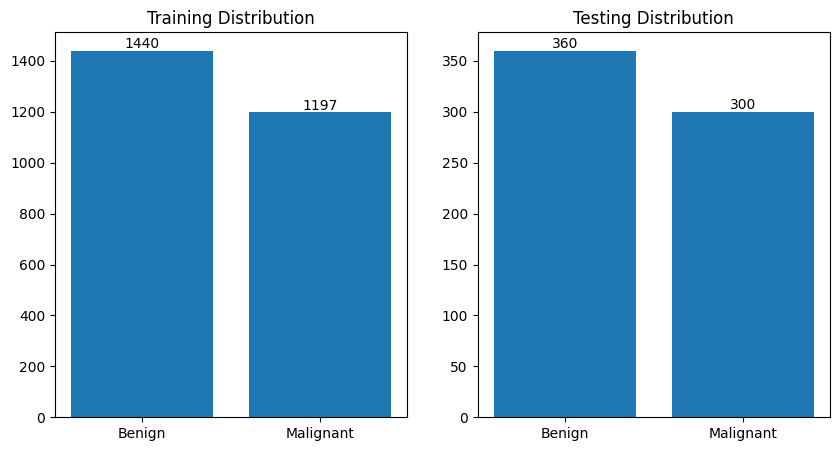

In [ ]:
# Plot the distribution with its percentage.
fig = plt.figure(figsize=(10, 5))

# Plot the train distribution
ax1 = fig.add_subplot(1, 2, 1)
ax1.bar(['Benign', 'Malignant'], train_dist)
ax1.bar_label(ax1.containers[0])
plt.title('Training Distribution')

# Plot the test distribution
ax2 = fig.add_subplot(1, 2, 2)
ax2.bar(['Benign', 'Malignant'], test_dist)
ax2.bar_label(ax2.containers[0])
plt.title("Testing Distribution")

In [ ]:
# Create the training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    labels = "inferred",
    batch_size = BATCH_SIZE,
    image_size = new_img_size
)

# Create the testing dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_path,
    labels = "inferred",
    batch_size = BATCH_SIZE,
    image_size = new_img_size
)

# Retrieve and print the list of class names for the dataset
class_names = test_dataset.class_names
print(class_names)

Lastly, we just want to configure our datasets for performance. This will help us out when we are training and testing the dataset.

In [ ]:
# Configures a dataset object to increase performance, including batching the dataset
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

# Configure both datasets to increase performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = configure_for_performance(train_dataset)
test_dataset = configure_for_performance(test_dataset)

Now, our dataset is all setup. So, we can start setting up our model.

# **Data Augmentation and Class Weights**

Now that we have split our data, we can go ahead and apply some transformations to it. To do this, we are going to make a short sequential tf model that will randomly apply transformations to the data. This will apply data augmentation across the whole training dataset evenly. So, this won't do anything to fix bias, or help fix the class imbalance that we saw earlier. To fix the class imbalance, we will use class weights. For normalization, there is a pre-processing method available specifically for the pre-trained network that we will be using. So, we will incorporate that when we are building the model itself.

In [ ]:
# Preset a random seed so that we can better compare different tests
rand_seed = 0

# Create a TF sequential model for data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal', seed=rand_seed),
  tf.keras.layers.RandomRotation(0.2, seed=rand_seed),
  tf.keras.layers.RandomBrightness(0.2, seed=rand_seed),
  tf.keras.layers.RandomContrast(0.2, seed=rand_seed),
])

Class weights are essentially just a number that we use as a multiplier with our loss function. The basic idea is that since we have less data for melanomas and carcinomas, we will try to learn more from those examples. How we do that, is by applying a constant multiplier to our loss function, depending on which class we are learning from. So, the less images that we have for a class, the bigger the number we multiply with.

In [ ]:
# Compute Class Weights
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=[0, 1],
                                                  y=df['label_ind'])


# Convert class weights to a dictionary and print the results
class_wt_dict = dict(enumerate(class_weights))
class_wt_dict

{0: 1.006490599820949, 1: 0.9935925762262483}

# **Setting up and Training a Pre-Trained Model**

Here, we are going to be setting up our model and then training it.

I reccomend using a GPU to speed up processing. Make sure that you enable this for your runtime with the steps in the setup section. Than you can use the code below to configure it with tensorflow. Just be warned, you are only allowed a certain amount of GPU usage by google without having to pay for more.

In [ ]:
# Check if GPU is accessible to TF
tf.config.list_physical_devices('GPU')
tf.debugging.set_log_device_placement(True)

# Get the GPU memory fraction to allocate
gpu_memory_fraction = 0.65

# Create GPUOptions with the fraction of GPU memory to allocate
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=gpu_memory_fraction)

# Create a session with the GPUOptions
session = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

Now we can start to use a pre-trained model to test this data out. We are going to be using the VGG16 model here, here is an image of the basic architecture of that model. Note, we are going to be removing the last softmax layer and replacing it with out own set of layers.

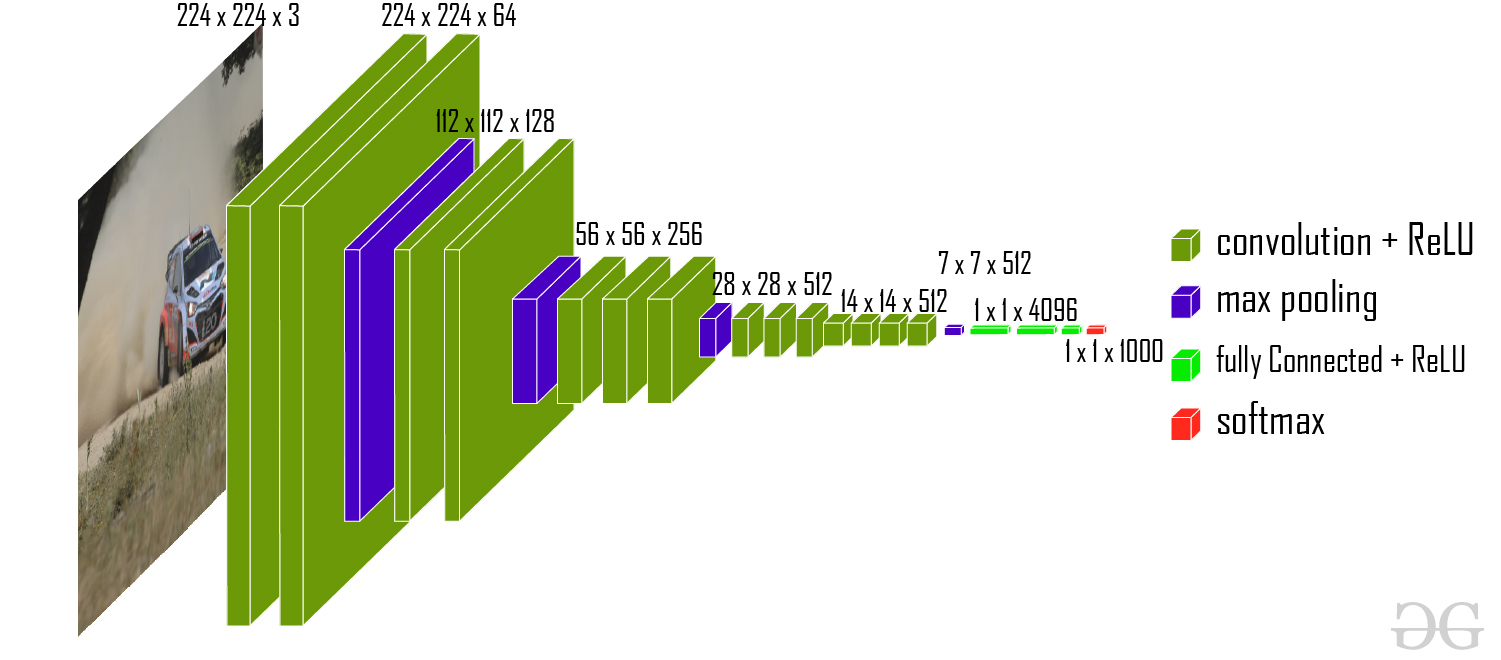

In this, we are loading up the fully trained model, but we are not including the final dense (fully connected) layers as we are going to put our own in. Also, we are going to set the remaining layers as not trainable, so that when we train the final model, we are only training the final dense layers.

To start, let import the VGG16 model and freeze it.

In [ ]:
# Load the pre-trained model
base_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Make all layers in the pre-trained model not trainable
for layer in base_model.layers:
    layer.trainable = False

# Print a summary of the base model
base_model.summary()

Now, we can make our whole model using the Tensorflow Functional API. We are going to combine our data augmentation model, a pre-processing layer, the vgg16 model, and then a series of dense layers, normalization layers, and activation layers.

In [ ]:
# THIS REPRESENTS THE NUMBER OF OUTPUT CLASSES (ie, Melanoma, Carcinoma, Benign)
IMG_SIZE = (224, 224, 3)

# Build the model (augment -> normalize -> pre-trained -> dense layers)
inputs = keras.Input(shape=IMG_SIZE)
x = data_augmentation(inputs)
x = tf.keras.applications.vgg16.preprocess_input(x)

x = base_model(x, training=False)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(32)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(16)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the Model
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy', tf.keras.metrics.AUC()])


# Define a callback that will call the garbage collector after each epoch
class RAM_management(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    gc.collect()


Now we can go ahead and train the model.

In [ ]:
# HYPER PARAMETERS
initial_epochs = 10

# Train the model
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=test_dataset,
    callbacks=[RAM_management()])

beep()

As a note, these models won't be as good as they can be. Making models is a highly iterative process that involves slowly tweaking different aspects of the model and data, in order to find the set-up that you can. Both learning how to and actually optimizing your model can take a while and so I wouldn't really worry about that too much right now. When we are making our own model later on, we will focus on that more.

Now, we should have a pretty good accuracy. But we can do better by fine-tuning the model. What this involves is "unfreezing" either the whole model, or just some of the layers that were previously frozen, and then continuing to train the model, but with a really low learning rate.

If you would like to know more about this process, you can visit the [tensorflow tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning#learning_curves) on this process.

In [ ]:
# Unfreeze the base model
base_model.trainable = True

# Recompile the model with a smaller learning rate
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy', tf.keras.metrics.AUC()])

In [ ]:
# Define the number of fine tune epochs
fine_tune_epochs = 12
total_epochs =  initial_epochs + fine_tune_epochs

# Fine tune the model
finetune_history = model.fit(train_dataset,
                             epochs=total_epochs,
                             validation_data=test_dataset,
                             initial_epoch=history.epoch[-1],
                             callbacks=[RAM_management()])

beep()

Before we continue, if you would like to save your model, run the code below to save it. Just make sure that the .keras file is either copied to your drive, or saved locally.

In [ ]:
# Run this if you want to save the current state of the model
model_name = 'bin_vgg16_fitz17k_model.keras'   # Change this to match your model
model.save(model_name)

# Copy the model file to a destination directory
copy_dest = None
!cp "$model_name" "$copy_dest"

Now, lets plot the training history of our model. Firstly, we'll print out the model's ROC-AUC training and validation history.

In [ ]:
# Combine the training and fine tuning history
auc = [0.] + history.history['auc']
val_auc = [0.] + history.history['val_auc']
auc += finetune_history.history['auc']
val_auc += finetune_history.history['val_auc']

# Plot the AUC graph
plt.figure(figsize=(8,4))
plt.plot(auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.ylim([0, 1])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')

Now, let's print out the model's training and validation accuracy and loss.

In [ ]:
# Combine the training and fine tuning accuracy and loss
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
acc += finetune_history.history['accuracy']
val_acc += finetune_history.history['val_accuracy']
loss += finetune_history.history['loss']
val_loss += finetune_history.history['val_loss']

# Create a figure for our plots
plt.figure(figsize=(8, 8))

# Plot the model's training/validation accuracy
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

# Plot the model's training/validation loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0,1.0])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.xlabel('epoch')

plt.show()

Now, we can go ahead and test our model to see how we did. Something that is important to remember though, is that we have a huge class imbalance in both the training and testing sets. So, we can only trust most of these metrics to such a degree. Let's start by getting a classification report.

In [ ]:
# Build a classification report
test_labels = [y for x, y in test_dataset.unbatch()]
test_predictions = np.argmax(model.predict(test_dataset), axis=-1)
print(classification_report(test_labels,test_predictions))

Next, lets plot our ROC-AUC curve.

In [ ]:
# Obtain the AUC false positive rates, true positive rates, and thresholds.
fpr, tpr, threshold = roc_curve(test_labels, test_predictions)
auc_val = auc(fpr, tpr)

In [ ]:
# Plot the ROC-AUC data
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Model (area = {:.3f})'.format(auc_val))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

That completes this notebook. However, we are not necessary done with these models. In other notebooks we are going to do more things.

1. Do in-depth testing on these models with separate datasets.
2. Fine-tune these models with separate datasets to increase accuracy and (hopefully) reduce bias.

# **Additional Resources**

Here's some additional resources that may be helpful.

**More about Google CoLabs**

[Introduction to Google CoLabs Video](https://www.youtube.com/watch?v=RLYoEyIHL6A)

[Official Google CoLabs Tutorial Notebook](https://colab.research.google.com/notebooks/welcome.ipynb#scrollTo=-Rh3-Vt9Nev9)

**Information about Metrics for Evaluating Models**

[Video talking about some common metrics used for Classification Models](https://www.youtube.com/watch?v=XiUlqN1Ay0U&list=LL&index=3)
- This goes into the code a little bit, but don't really worry about that part of it.

[Good video talking about evaluation metrics overall](https://www.youtube.com/watch?v=LbX4X71-TFI&list=LL&index=4&t=22s)
- She goes into some metrics for regression models, but don't worry about those as we are only doing classification.


**Using data augmentation to fix data imbalance**

[Image Augmentation for Imbalanced Medical Datasets
](https://www.youtube.com/watch?v=B-YA-pfVOrY)